# Simulations

This notebook is used to run simulations on an environment. The reason why we do it in an notebook is because we can reuse calculated policies. As calculating policies with policiy iteration can take time, this safes time and resources.

## 1. Running simulations for crossing env with optimal policy

### 1.1 Load environments and create envs

In [1]:
from utils import load_env_configs, process_config
from probabilistic_minigrids import ProbabilisticEnvWrapper

configs = load_env_configs("./goal_state_envs.yaml")
crossing_env_config = process_config(configs[0])

env_instance = crossing_env_config['env_class'](**crossing_env_config['env_params'])
crossing_env_prob = ProbabilisticEnvWrapper(env_instance, crossing_env_config['used_actions'], crossing_env_config['prob_distribution'])
crossing_env_prob.add_lava() 
crossing_env_storm_model, _ = crossing_env_prob.convert_to_probabilistic_storm()

/home/noah/Noah_tmp/thesis/Minigrid2Storm/.venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Environment already contains lava hazards.


### 1.2 Find optimal policy

In [2]:
from utils import custom_policy_iteration

goal_maximization = "Pmax=? [F \"goal\"]"

print("Running policy iteration...")
result, scheduler = custom_policy_iteration(crossing_env_prob.model, prop=goal_maximization, visualize=False)


Running policy iteration...


### 1.3 Run simulation

### Without Delta Shield

In [4]:
from simulations import run_simulation



reach_goal_baseline, reach_lava_baseline, reach_truncated_baseline = run_simulation(crossing_env_prob, scheduler, num_episodes=1000)
print(f"reach_goal:{reach_goal_baseline}, reach_lava:{reach_lava_baseline}, reach_truncated:{reach_truncated_baseline}")

reach_goal:917, reach_lava:83, reach_truncated:0


### With Delta Shield

WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized for scheduler extraction. Initializing now, but this is inefficient.
WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized for scheduler extraction. Initializing now, but this is inefficient.
WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized for scheduler extraction. Initializing now, but this is inefficient.
DEBUG: Shield blocked 0 actions and validated 47743
DEBUG: Shield blocked 0 actions and validated 47743
WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized for scheduler extraction. Initializing now, but this is inefficient.
WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized for scheduler extraction. Initializing now, but this is inefficient.
WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized

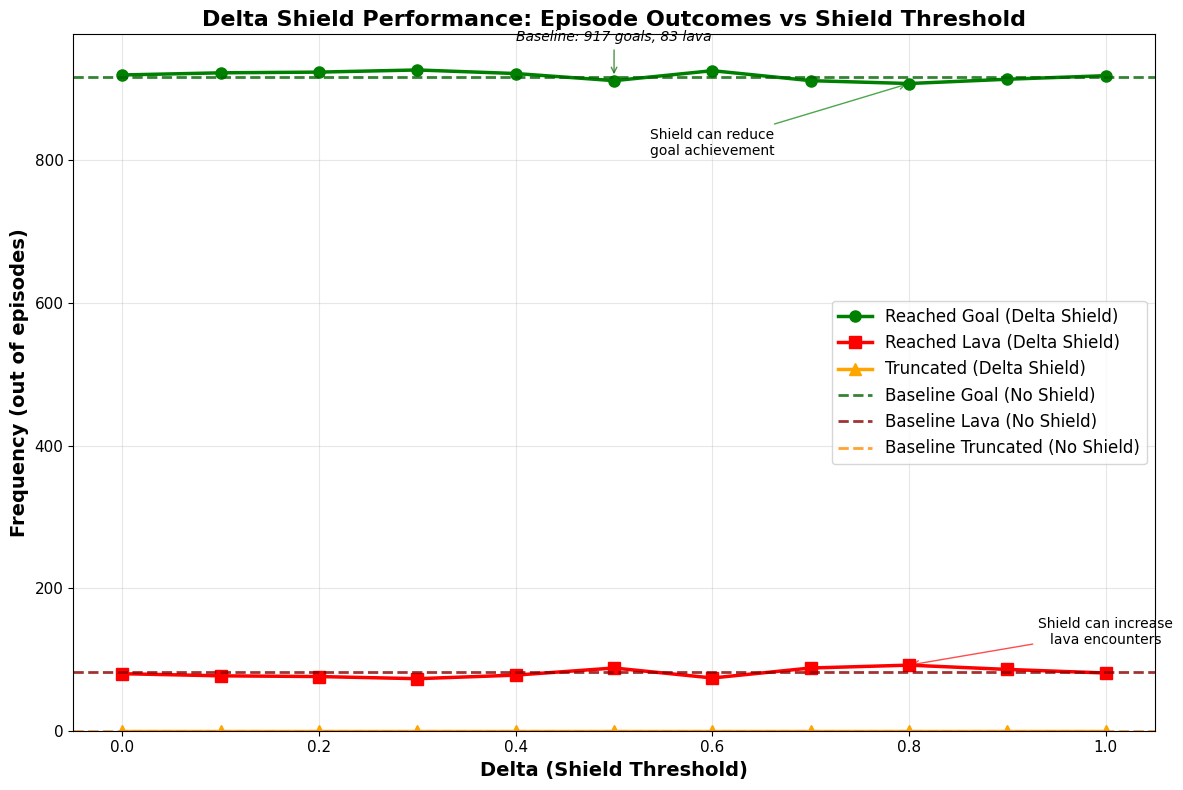

Delta Shield Performance Summary:
BASELINE (No Shield): 917 goals, 83 lava, 0 truncated

DELTA SHIELD RESULTS:
Best goal achievement: 927 episodes at delta = 0.3
Worst lava encounters: 92 episodes at delta = 0.8
Average goal achievement: 918.8 episodes
Average lava encounters: 81.2 episodes

COMPARISON TO BASELINE:
Goal achievement: Baseline = 917, Shield avg = 918.8 (+1.8)
Lava encounters: Baseline = 83, Shield avg = 81.2 (-1.8)


In [5]:
from shield import DeltaShield
from plotting import plot_delta_shield_performance
deltas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
goal =[]
lava = []
truncated = []


for delta in deltas:
    shield = DeltaShield(crossing_env_storm_model, "Pmin=? [F \"lava\"]", delta=delta)
    reach_goal, reach_lava, reach_truncated = run_simulation(crossing_env_prob, scheduler, shield=shield, num_episodes=1000)
    goal.append(reach_goal)
    lava.append(reach_lava)
    truncated.append(reach_truncated)

plot_delta_shield_performance(
    deltas_list=deltas,
    goal_list=goal, 
    lava_list=lava,
    truncated_list=truncated,
    baseline_goal=reach_goal_baseline, 
    baseline_lava=reach_lava_baseline,
    baseline_truncated=reach_truncated_baseline
)


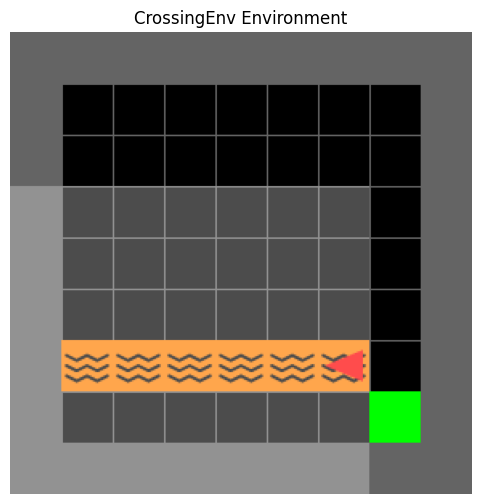

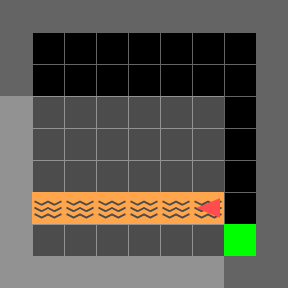

In [6]:
# Quick function to render the environment
def render_env(env):
    """Render the environment and display it as an image"""
    from PIL import Image
    import matplotlib.pyplot as plt
    
    # Get the RGB array from the environment
    rgb_array = env.render()
    
    # Convert to PIL Image and display
    img = Image.fromarray(rgb_array)
    
    # Display using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('CrossingEnv Environment')
    plt.show()
    
    return img

# Render the current environment
render_env(crossing_env_prob)